### Essaymaker Agent flow

#### Initialize variables

In [94]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv('/Users/felipe_q/Desktop/AI_models/Agents/agent_venv/Agent_Development/langraph/credentials.env'))

True

In [95]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage


#memory = SqliteSaver.from_conn_string(":memory:")
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

### Initialize Agent class

In [96]:
class AgentState(TypedDict):

    task: str #Human Input.
    plan: str #This will be generated by the planning Agent
    draft: str
    critique: str
    content: List[str] # List of documents that Tavily has researched about.
    revision_number: int #Keepo track of the revisions we have made.
    max_revisions: int #Criteria wheter to stop or not.

In [97]:
# We define our agent
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-5-nano")

### We define the prompts - Each prompt is designed to create different Agents. 1 prompt = 1 Agent.

In [98]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [99]:
## Function to make sure we are getting a list of strings from the language model

from langchain_core.pydantic_v1 import BaseModel #Represents the results that we want to get back from the model.

class Queries(BaseModel):
    queries: List[str] #In this case is a list of strings.

In [100]:
#Importing the Tavily Client
from tavily import TavilyClient
tavily = TavilyClient()

In [101]:
# We initialize with the planning agent.

def plan_node(state: AgentState):
    print(f'This is the current state: {state}')
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}
    

#The following function takes the plan of the previous functions and we do some research based on that output

def research_plan_node(state: AgentState):

    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content = RESEARCH_PLAN_PROMPT),
        HumanMessage(content = state['task'])
    ])

    content = state.get('content',[])
    for q in queries.queries:
        response = tavily.search(query = q, max_results =2)
        for r in response['results']:
            content.append(r['content'])
    
    return {'content': content}
    
# Based on the research made in the previous function, we will be generating the first draft.


def generation_node(state: AgentState):
    
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content = f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    
    messages = [
        SystemMessage(
            content = WRITER_PROMPT.format(content = content)
        ),
        user_message]
    
    response = model.invoke(messages)
    return {'draft': response.content, 'revision_number': state.get('revision_number',1)+1}

def reflection_node(state: AgentState):

    messages = [
        SystemMessage(content = REFLECTION_PROMPT),
        HumanMessage(content = state['draft'])
    ]
    response = model.invoke(messages)
    return {'critique': response.content}

def research_critique_node(state: AgentState):

    queries = model.with_structured_output(Queries).invoke([

        SystemMessage(content = RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content = state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:

        response = tavily.search(query = q, max_results =2)
        for r in response['results']:
            content.append(r['content'])

        return{'content': content}

In [102]:
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    
    return "reflect"

### Now putting it together for a Graph

In [103]:
builder = StateGraph(AgentState)

In [104]:
builder.add_node('planner', plan_node)
builder.add_node('research_plan', research_plan_node)
#builder.add_node('reflect', reflection_node)
#builder.add_node('research_critique', research_critique_node)
#builder.add_node('generate', generation_node)

### First Node

In [105]:
builder.set_entry_point('planner')

### Second Node 

builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, 'reflect': 'reflect'}
)

In [106]:
builder.add_edge('planner', 'research_plan')
#builder.add_edge('research_plan', 'generate')
#builder.add_edge('reflect', 'research_critique')
#builder.add_edge('research_critique', 'generate')

In [107]:
graph = builder.compile(checkpointer = memory)

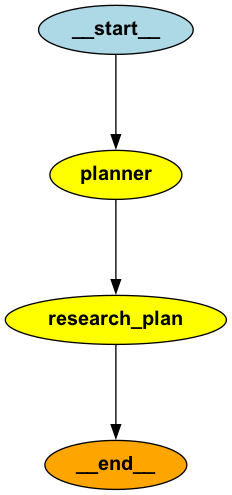

In [108]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [109]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)


This is the current state: {'task': 'what is the difference between langchain and langsmith', 'revision_number': 1, 'max_revisions': 2}
{'planner': {'plan': 'Outline: LangChain vs. LangSmith — What’s the Difference?\n\nThesis/central idea\n- LangChain is a programming framework for building LLM-powered applications.\n- LangSmith is a companion platform designed to observe, test, and evaluate LangChain apps.\n- Together, they serve complementary roles: LangChain provides the building blocks; LangSmith provides visibility, quality assurance, and reproducibility for those builds.\n\n1) Introduction\n- Purpose: Introduce the topic and why understanding the difference matters for developers and teams.\n- Key points to cover:\n  - Brief definitions of LangChain and LangSmith.\n  - The practical question: “What should I use for building vs. testing/observing?”\n  - A short roadmap of what the essay will cover.\n- Notes for writing:\n  - Frame LangChain as the toolkit and LangSmith as the cock

/Users/felipe_q/Desktop/AI_models/Agents/agent_venv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_plan': {'content': ['*   [Platform](https://blog.promptlayer.com/langchain-vs-langsmith/#t) *   [-- Prompt Management](https://www.promptlayer.com/platform/prompt-management) *   [-- Evaluations](https://www.promptlayer.com/platform/evaluations) ![Image 2: LangChain vs LangSmith: A Developer-Focused Comparison](https://blog.promptlayer.com/content/images/2025/05/How-a-Prompt-Engineering-Tool-Improves-AI-Model-Performance--100-.png) In LLM application development, LangChain and LangSmith have become central tools for building and managing large language model-powered solutions. This article compares LangChain and LangSmith, focusing on their core features, integration options, and value for developers in the LLM application space. LangChain is an open-source framework that helps developers create LLM applications efficiently. LangSmith provides tools to debug, monitor, and improve LLM-powered agents, and offers a managed cloud service with a web UI. | LLM Evaluation | Minimal